In [24]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import altair as alt
from vega_datasets import data


def beta_binomial_abtest(control_observations, control_users, variant_observations, variant_users, tune = 1000, draws = 5000):
    with pm.Model():
        pm.Binomial("control_bin", n=control_users, p=pm.Beta('control', 1, 99), observed=control_observations)
        pm.Binomial("variant_bin", n=variant_users, p=pm.Beta('variant', 1, 99), observed=variant_observations)
        trace = pm.sample(return_inferencedata=True, tune=tune, draws=draws)
        
    return trace

def calc_ci_perc(ci_point, control_mean):
    return round((float(ci_point) - control_mean) / control_mean * 100, 1)

def bayesian_statement(trace, control_mean, variant_label, control_label = "Control", confidence_level = 0.9):
    ci = az.hdi(trace, hdi_prob=confidence_level)["variant"]
    return f"There is a {confidence_level*100:.0f}% chance that the difference for {variant_label} in respect to {control_label} is between {calc_ci_perc(ci[0], control_mean)}% and {calc_ci_perc(ci[1], control_mean)}%"


def plot_control_variant_diff(trace, title, xlimit = 60, bins = 50):
    control_farray = np.array(trace["posterior"]["control"]).flatten()
    variant_farray = np.array(trace["posterior"]["variant"]).flatten()
    diff = variant_farray - control_farray
    diff_perc = (diff / control_farray.mean()) * 100 
    densities, edges = np.histogram(diff_perc, density=True, bins=bins, range=(-xlimit, xlimit))
    densities = densities*np.diff(edges)*100
    plt.subplots(figsize=(16, 8))
    for i in range(edges.shape[0]):
        if edges[i] >= 0:
            break

    plt.bar(edges[:i], densities[:i], width=np.diff(edges[:i+1]), color="orange", edgecolor="red", align="edge")
    plt.bar(edges[i:-1], densities[i:], np.diff(edges[i:]), color="lightgreen", edgecolor="green", align="edge")
    plt.axvline(0, color="black", linestyle="--")
    plt.axvline(diff_perc.mean(), color="blue", linestyle="-", label=f"mean change ({diff_perc.mean():.2f}%)")
    plt.xlabel("% change conversion")
    plt.ylabel("% chance")
    plt.title(title)
    plt.legend(fontsize = 15)
    

def quick_results(control_observations, control_users, variant_observations, variant_users, title = "", tune = 1000, draws = 5000, xlimit = 60, bins = 50, variant_label="Variant", control_label = "Control", confidence_level = 0.9):
    """
    Runs the Beta-Binomial model in the background and returns the result plot. 
    """
    trace = beta_binomial_abtest(control_observations, control_users, variant_observations, variant_users)
    return plot_control_variant_diff(trace, title, xlimit, bins), bayesian_statement(trace, control_observations / control_users, variant_label, control_label = "Control", confidence_level = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control, variant]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


(None,
 'There is a 90% chance that the difference for Variant in respect to Control is between 3.7% and 13.8%')

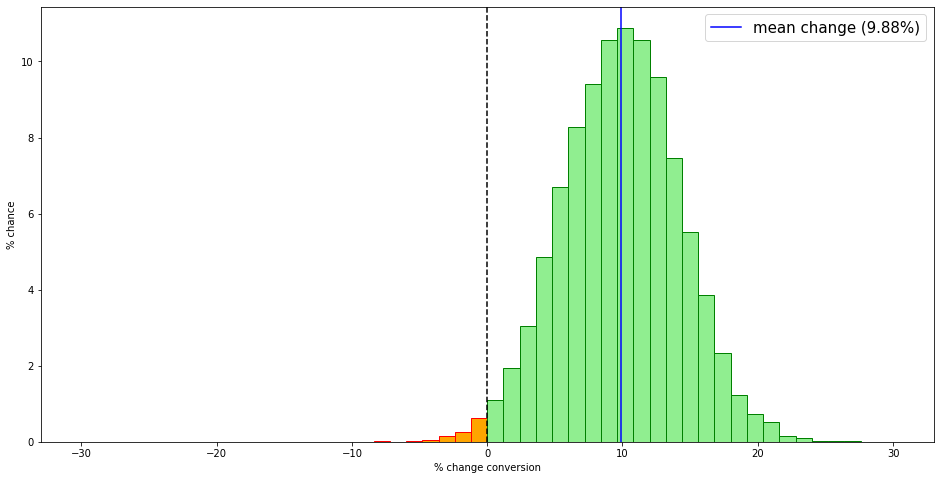

In [2]:
quick_results(1000, 10000, 1100, 10010, xlimit = 30)

In [30]:
trace = beta_binomial_abtest(1000, 10000, 1100, 10010)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control, variant]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.


In [94]:
bins = 50
xlimit = 20
control_farray = np.array(trace["posterior"]["control"]).flatten()
variant_farray = np.array(trace["posterior"]["variant"]).flatten()
diff = variant_farray - control_farray
diff_perc = (diff / control_farray.mean()) * 100 
densities, edges = np.histogram(diff_perc, density=True, bins=bins, range=(-xlimit, xlimit))
densities = densities*np.diff(edges)*100
for i in range(edges.shape[0]):
    if edges[i] >= 0:
        break

negative_bar = alt.Chart(pd.DataFrame({'x': edges[:i], 'y': densities[:i]})).mark_bar(size=20).encode(
    alt.X('x',
        scale=alt.Scale(domain=(-xlimit, xlimit)),
        axis=alt.Axis(title='% difference')
    ),
    y='y',
    color=alt.ColorValue("red"),
)
positive_bar = alt.Chart(pd.DataFrame({'x': edges[i:-1], 'y': densities[i:]})).mark_bar(size=20).encode(
    x='x',
    y='y',
    color=alt.ColorValue("lightgreen"),
)

zero_line = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule().encode(x='x')

diff_plot = negative_bar + positive_bar + zero_line
diff_plot.properties(
    width=1500,
    height=600
)


alt.LayerChart(...)

In [89]:
x = alt.Chart(pd.DataFrame({'x': edges[:i], 'y': densities[:i]}))
x.mark_bar?

Signature:
x.mark_bar(
    align=Undefined,
    angle=Undefined,
    aria=Undefined,
    ariaRole=Undefined,
    ariaRoleDescription=Undefined,
    aspect=Undefined,
    bandSize=Undefined,
    baseline=Undefined,
    binSpacing=Undefined,
    blend=Undefined,
    clip=Undefined,
    color=Undefined,
    continuousBandSize=Undefined,
    cornerRadius=Undefined,
    cornerRadiusBottomLeft=Undefined,
    cornerRadiusBottomRight=Undefined,
    cornerRadiusEnd=Undefined,
    cornerRadiusTopLeft=Undefined,
    cornerRadiusTopRight=Undefined,
    cursor=Undefined,
    description=Undefined,
    dir=Undefined,
    discreteBandSize=Undefined,
    dx=Undefined,
    dy=Undefined,
    ellipsis=Undefined,
    fill=Undefined,
    fillOpacity=Undefined,
    filled=Undefined,
    font=Undefined,
    fontSize=Undefined,
    fontStyle=Undefined,
    fontWeight=Undefined,
    height=Undefined,
    href=Undefined,
    innerRadius=Undefined,
    interpolate=Undefined,
    invalid=Undefined,
    limit=Unde

In [58]:
alt.Chart(df).mark_circle().encode(
    x=alt.X('x', axis=alt.Axis(format='%', title='percentage')),
    y=alt.Y('y', axis=alt.Axis(format='$', title='dollar amount'))
)


NameError: name 'df' is not defined

<BarContainer object of 25 artists>

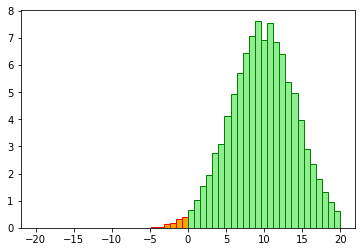

In [52]:
plt.bar(edges[:i], densities[:i], width=np.diff(edges[:i+1]), color="orange", edgecolor="red", align="edge")
plt.bar(edges[i:-1], densities[i:], np.diff(edges[i:]), color="lightgreen", edgecolor="green", align="edge")